# imputation and modeling
sklearn modeling the median imputed training data using min/max clinically guided aggregation. 
preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

# importing and formatting dataset

In [2]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df

#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]



time: 1.49 s


In [3]:
#save_path= str(repository_path)+'/data/cleaned_merged_agg/'
  
address=str(repository_path)+'/data/cleaned_merged_agg/'+'%s/'%(folder)
train_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'train')), index_col=0)
test_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'test')), index_col=0)

time: 145 ms


In [4]:
train_data.head()

,icustay_id,any_vasoactives,bilirubin,bun,cancer_elix,chloride,creatinine,daily_sofa,dobutamine,dopamine,...,"('min', 'calcium')","('min', 'sodium')","('min', 'wbc')",ethnicity,gender,bands,pao2fio2ratio,pco2,weight,yearsold
0,200012.0,0.0,NaN,NaN,0.0,NaN,NaN,-0.430677,0.0,0.0,...,NaN,NaN,-0.319914,asian,0.0,>10,"(475, 3000]",absent,51.2,32.988959
1,200014.0,0.0,NaN,0.040770,0.0,0.037089,-0.300758,-0.178747,0.0,0.0,...,-0.044882,0.014580,0.125353,unknown/other,1.0,absent,"(200, 333]",<50,62.0,84.728186
2,200033.0,1.0,NaN,-0.082229,1.0,-0.004314,-0.219047,-0.430677,0.0,0.0,...,-0.505654,-0.011213,-0.195493,white/nonhispanic,1.0,absent,"(475, 3000]",absent,74.0,67.145099
3,200036.0,0.0,NaN,NaN,0.0,NaN,NaN,-0.430677,0.0,0.0,...,NaN,NaN,NaN,white/nonhispanic,1.0,absent,"(475, 3000]",absent,79.0,74.934136
4,200055.0,0.0,-0.316061,0.098917,0.0,-0.035714,1.934240,0.503859,0.0,0.0,...,-0.135281,-0.003710,-0.260497,NaN,NaN,absent,"(475, 3000]",absent,56.0,NaN


time: 34.5 ms


## getting descriptive numbers for publication

In [5]:
final_pt_df2.head()#['icustay_id'].nunique()

,icustay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,subject_id,dod_hosp,dod_ssn,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin,hadm_id
0,294638,2191-03-16 00:00:00,22,2191-03-16 00:29:31,1213116,2191-03-16,2191-03-22,0 days 00:00:00.000000000,2191-03-16,2191-03-22,...,4,NaN,NaN,full,STAPH AUREUS COAG +,BLOOD CULTURE,2191-03-16 00:00:00,positive,C_pos/A_full,185777
1,220597,2149-11-10 09:40:00,45,2149-11-09 13:07:02,2089126,2149-11-10,2149-11-15,0 days 00:00:00.000000000,2149-11-10,2149-11-15,...,9,2149-11-14,2149-11-14,full,NaN,NaN,2149-11-10 09:40:00,negative,C_neg/A_full,150750
2,232669,2104-08-11 00:00:00,60,2104-08-08 02:08:17,616189,2104-08-11,2104-08-12,0 days 00:00:00.000000000,2104-08-11,2104-08-12,...,12,2104-08-20,2104-08-20,partial,NaN,NaN,2104-08-11 00:00:00,negative,C_neg/A_partial,112213
3,273430,2108-08-05 20:42:00,69,2108-08-05 16:26:09,2572274,2108-08-06,2108-08-08,1 days 00:00:00.000000000,2108-08-06,2108-08-08,...,19,NaN,2109-08-18,partial,NaN,NaN,2108-08-05 20:42:00,negative,C_neg/A_partial,109235
4,217847,2134-09-11 09:35:00,70,2134-09-11 20:50:04,1388217,2134-09-12,2134-09-13,1 days 00:00:00.000000000,2134-09-12,2134-09-13,...,21,2135-02-08,2135-02-08,full,NaN,NaN,2134-09-11 09:35:00,negative,C_neg/A_full,109451


time: 28.3 ms


In [6]:
list(train_data)

['icustay_id',
 'any_vasoactives',
 'bilirubin',
 'bun',
 'cancer_elix',
 'chloride',
 'creatinine',
 'daily_sofa',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'leukocyte',
 'nitrite',
 'norepinephrine',
 'o2_flow',
 'phenylephrine',
 'potassium',
 'ptt',
 'resprate',
 'rrt',
 'sum_elix',
 'temperature',
 'vasopressin',
 'vent_recieved',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 "('max', 'calcium')",
 "('max', 'sodium')",
 "('max', 'wbc')",
 "('min', 'calcium')",
 "('min', 'sodium')",
 "('min', 'wbc')",
 'ethnicity',
 'gender',
 'bands',
 'pao2fio2ratio',
 'pco2',
 'weight',
 'yearsold']

time: 2.88 ms


In [7]:
full_demo=pd.concat([train_data[['icustay_id','yearsold','ethnicity','gender']],test_data[['icustay_id','yearsold','ethnicity','gender']]])

time: 11.6 ms


In [8]:
full_demo.describe()

,icustay_id,yearsold,gender
count,10305.000000,6831.000000,6831.000000
mean,249857.183212,64.355019,0.552042
std,28968.046750,17.763457,0.497321
min,200012.000000,16.022154,0.000000
25%,224498.000000,52.468778,0.000000
50%,249804.000000,66.219555,1.000000
75%,275055.000000,78.838347,1.000000
max,299995.000000,90.000000,1.000000


time: 42 ms


In [9]:
full_demo

,icustay_id,yearsold,ethnicity,gender
0,200012.0,32.988959,asian,0.0
1,200014.0,84.728186,unknown/other,1.0
2,200033.0,67.145099,white/nonhispanic,1.0
3,200036.0,74.934136,white/nonhispanic,1.0
4,200055.0,NaN,NaN,NaN
5,200059.0,78.897340,white/nonhispanic,0.0
6,200061.0,45.751386,unknown/other,1.0
7,200075.0,83.641367,white/nonhispanic,0.0
8,200085.0,55.990915,black,1.0
9,200091.0,69.717042,unknown/other,1.0


time: 38.2 ms


In [10]:
full_demo.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    7867
C_pos/A_full       2438
Name: final_bin, dtype: int64

time: 31.6 ms


In [11]:
full_demo['yearsold'].min()

16.0221538076406

time: 7.33 ms


In [12]:
full_demo['ethnicity'].value_counts()

white/nonhispanic    4906
unknown/other         845
black                 602
hispanic              280
asian                 198
Name: ethnicity, dtype: int64

time: 13 ms


In [13]:
full_demo['gender'].value_counts()

1.0    3771
0.0    3060
Name: gender, dtype: int64

time: 7.49 ms


In [14]:
test_data[['icustay_id','yearsold','ethnicity','gender']]

,icustay_id,yearsold,ethnicity,gender
0,200030.0,54.191893,black,1.0
1,200063.0,37.073163,unknown/other,1.0
2,200078.0,NaN,NaN,NaN
3,200109.0,NaN,NaN,NaN
4,200116.0,56.506077,white/nonhispanic,1.0
5,200141.0,74.588570,white/nonhispanic,0.0
6,200215.0,NaN,NaN,NaN
7,200252.0,76.432487,white/nonhispanic,1.0
8,200347.0,NaN,NaN,NaN
9,200349.0,81.614415,black,0.0


time: 40.1 ms


In [15]:
train_data.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 34.3 ms


## back to the modeling

In [16]:
def preprocessing(preimp_df):

    """
    function operations:
    1) rename columns
    2) standardize last 2 columns to be standardized
    3) convert categorical columns to proper format
    4) median impute
    """
    from sklearn.impute import SimpleImputer
        
    rename_dic={
    "('max', 'sodium')": "maxSodium" ,
    "('max', 'sodium')" : "maxSodium",
    "('min', 'sodium')" : "minSodium",
    "('max', 'calcium')" : "maxCalcium",
    "('min', 'calcium')" : "minCalcium",
    "('max', 'sodium')": "maxSodium",
    "('min', 'sodium')": "minSodium",
    "('max', 'wbc')": "maxWBC",
    "('min', 'wbc')": "minWBC",
    "bands": "ibands",
    "pco2": "ipco2"
        }
    data=preimp_df.copy()
    data=data.rename(rename_dic, axis='columns').copy()
    data.loc[data['yearsold']>90,"yearsold"]=90
    
    
    #train_data=data.copy()
    weight_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).median()
    age_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.25)
    age_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    data['weight']=data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    data['yearsold']=data['yearsold'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    ### onehot encoding categorical var
    cols_to_transform=['ethnicity', 'ibands', 'ipco2',
                       'any_vasoactives',"leukocyte","nitrite",
                       'pao2fio2ratio', 'vent_recieved',  "dobutamine",
                       "dopamine","epinephrine","norepinephrine",
                       "phenylephrine","rrt","vasopressin",'cancer_elix' ]
    data = pd.get_dummies(data, columns = cols_to_transform, drop_first=True)
    
    
    #binarizing and poping outcome for training data
    data.loc[data['final_bin']=="C_pos/A_full","final_bin"]=1
    data.loc[data['final_bin']=="C_neg/A_partial","final_bin"]=0
    data['final_bin']=pd.to_numeric(data['final_bin'])
    
    
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    data=pd.DataFrame(imp.fit_transform(data), columns=list(data))

    ## establishing training data and labels
    x_train= data.copy()
    z_icustay_id=x_train.pop('icustay_id')
    y_train= x_train.pop("final_bin").values
    
    return(x_train, y_train, z_icustay_id)

# x_train, y_train, z_icustay_id= preprocessing(pd.merge(preimp_train_df, final_pt_df2[['icustay_id','final_bin']]))

time: 178 ms


In [17]:

# x_train, y_train, z_icustay_id= preprocessing(pd.merge(preimp_train_df, final_pt_df2[['icustay_id','final_bin']]))

time: 995 µs


In [18]:
x_train, y_train, z_icustay_id = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]))
x_test, y_test, z_icustay_id_test= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]))

time: 393 ms


In [19]:
len(list(x_train))

57

time: 3.67 ms


### getting table for paper

In [20]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'o2_flow',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'gender',
 'weight',
 'yearsold',
 'ethnicity_black',
 'ethnicity_hispanic',
 'ethnicity_unknown/other',
 'ethnicity_white/nonhispanic',
 'ibands_>10',
 'ibands_absent',
 'ipco2_>50',
 'ipco2_absent',
 'any_vasoactives_1.0',
 'leukocyte_1.0',
 'nitrite_1.0',
 'pao2fio2ratio_(200, 333]',
 'pao2fio2ratio_(333, 475]',
 'pao2fio2ratio_(475, 3000]',
 'vent_recieved_1.0',
 'vent_recieved_2.0',
 'dobutamine_1.0',
 'dopamine_1.0',
 'epinephrine_1.0',
 'norepinephrine_1.0',
 'phenylephrine_1.0',
 'rrt_1.0',
 'vasopressin_1.0',
 'cancer_elix_1.0']

time: 3.31 ms


In [21]:
pd.merge(train_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 27.2 ms


In [22]:
pd.merge(test_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    2355
C_pos/A_full        745
Name: final_bin, dtype: int64

time: 28.4 ms


#### optional qc

In [23]:
#x_train.iloc[1:5, 25:45]

time: 1.45 ms


In [24]:
#x_train.iloc[1:5, 35:65]

time: 691 µs


In [25]:
#x_train.iloc[1:5, 10:30]

time: 394 µs


## looking at correlation of all variables

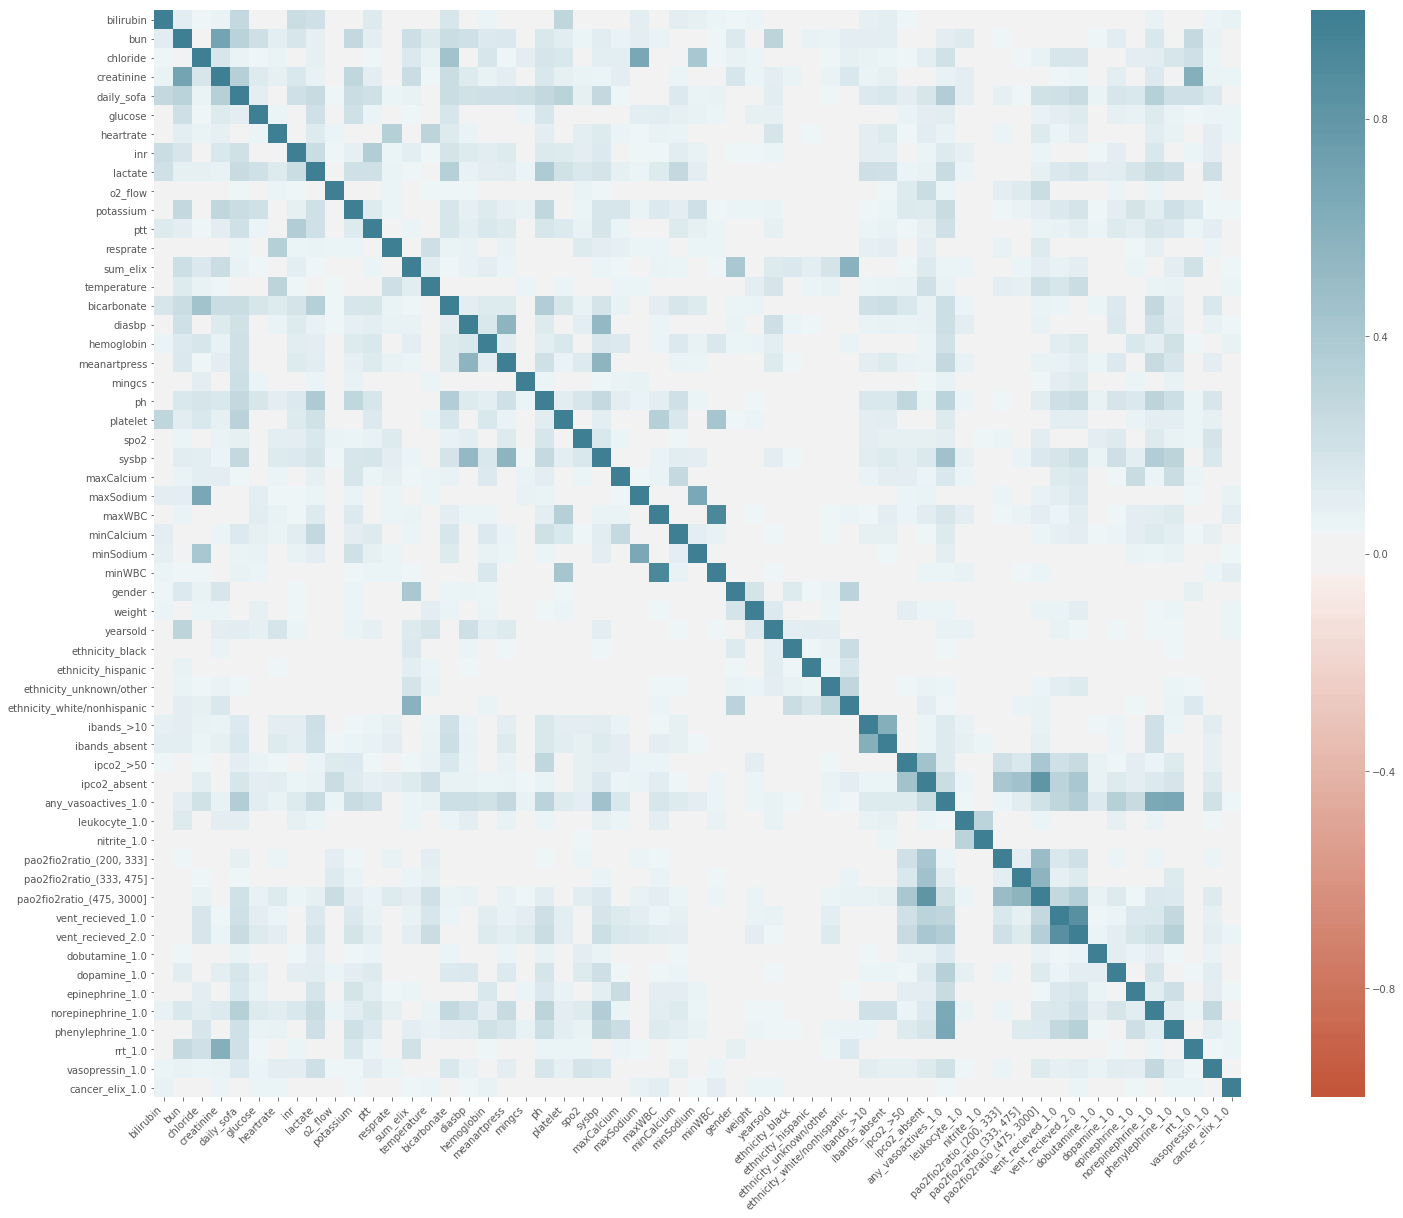

time: 2.48 s


In [26]:
corr = x_train.corr().abs()

plt.figure(figsize=(25, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [27]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,maxWBC,minWBC,0.915240
1,vent_recieved_1.0,vent_recieved_2.0,0.853540
2,ipco2_absent,"pao2fio2ratio_(475, 3000]",0.814699


time: 21.9 ms


### DROPING one of the 2 columns with correlation >0.7

	corx	cory	corr
0	ipco2_absent	pao2fio2Ratio_(475, 3000]	0.872418
1	maxWBC	minWBC	0.802373
2	bun	creatinine	0.720861
3	maxSodium	minSodium	0.704233

In [28]:
x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# all_xy.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# all_xy_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 7.18 ms


### formatting x and y for modleing

In [29]:
x=np.array(x_train.copy())
y=y_train.copy() #copy of y_train
y=y.astype('int')
#time_interval=4

time: 4.28 ms


In [30]:
print(len(x_train),len(x_test))

7205 3100
time: 1.15 ms


In [31]:
len(list(x_train))

54

time: 2.47 ms


# Modelbuilding
## test entire trainset and predict trainset.
* step1) hypertune models on 10fold cv.  
* step2) test entire train set and predict testset.
* step3) generate figures

## step1) XGB hypertuning

In [32]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(test_features)
    errors = abs(y_hat - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    auc=roc_auc_score(test_labels, y_hat)
    loss= log_loss(test_labels, y_hat)
    
    print ('the AUC is: {:0.3f}'.format(auc))
    print ('the logloss is: {:0.3f}'.format(loss))
    print(confusion_matrix(test_labels, y_hat))
    
    return loss

time: 17.3 ms


In [33]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, base_model, scoring="neg_log_loss", gridsearch=True, n_iter=20): 
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=nfolds,
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    grid_search.fit(X, y)    
    
    print("Grid scores on development set:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    #grid_search.best_params_
    print(grid_search.best_score_)
    print("\n")
    print(grid_search.best_params_)
    
    print('\n base model:')
    base_model = base_model#(random_state = 42)
    base_model.fit(x, y)
    base_auc = evaluate(base_model, x, y)
    
    print('\n hypertuned model:')
    best_random = grid_search.best_estimator_
    random_auc = evaluate(best_random, x, y)

    print('logloss change of {:0.2f}%. after hypertuning on training set (may be overfit)'.format( 100 * (random_auc - base_auc) / base_auc))
    
    print(grid_search.best_estimator_)
    
    return(grid_search)

time: 85.6 ms


In [34]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)
scale_pos_weight = [0.1, 1, 5, 10]
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}

base_model=XGBClassifier(random_state = 42)
xgboost_hyper=hypertuning_fxn(x, y, nfolds=5, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=20, gridsearch=True)

Grid scores on development set:
-0.538 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 0.1}
-0.541 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 1}
-0.727 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 5}
-0.874 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 10}
-0.531 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 0.1}
-0.527 (+/-0.006) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 1}
-0.700 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 5}
-0.840 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 10}
-0.526 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 0.1}
-0.518 (+/-0.006) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1}
-0.679 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 5}
-0.813 (+/-0.004) for {'l

In [35]:
###rf
#{'bootstrap': False, 'class_weight': None, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
# Number of trees in random forest
n_estimators = [10, 200]#[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,'auto', 10]
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

model= RandomForestClassifier(criterion='entropy')
base_model=RandomForestClassifier(random_state = 42, criterion='entropy')

rf_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss",n_iter = 25, gridsearch=True)


Grid scores on development set:
-0.477 (+/-0.019) for {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
-0.477 (+/-0.013) for {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
-0.480 (+/-0.015) for {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
-0.476 (+/-0.014) for {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
-0.480 (+/-0.014) for {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}
-0.476 (+/-0.013) for {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_

In [36]:
### 10/30 model:
# RandomForestClassifier(bootstrap=False, class_weight=None,
#             criterion='entropy', max_depth=25, max_features=10,
#             max_leaf_nodes=None, min_impurity_decrease=0.0,
#             min_impurity_split=None, min_samples_leaf=5,
#             min_samples_split=5, min_weight_fraction_leaf=0.0,
#             n_estimators=200, n_jobs=None, oob_score=False,
#             random_state=None, verbose=0, warm_start=False)

time: 1.19 ms


## Hypertune SVC

In [37]:
model= svm.SVC(probability=True)
kernel = ['linear', 'rbf', 'poly']
gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [0.1, 1, 10, 100] #Penalty parameter C of the error term.
degree = [0, 1, 2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

base_model=svm.SVC(probability=True)

svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=10, gridsearch=False)

Grid scores on development set:
-0.469 (+/-0.006) for {'kernel': 'rbf', 'gamma': 0.1, 'degree': 1, 'class_weight': None, 'C': 1}
-0.477 (+/-0.019) for {'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'class_weight': None, 'C': 1}
-0.450 (+/-0.011) for {'kernel': 'linear', 'gamma': 1, 'degree': 2, 'class_weight': 'balanced', 'C': 10}
-0.497 (+/-0.007) for {'kernel': 'rbf', 'gamma': 1, 'degree': 2, 'class_weight': None, 'C': 1}
-0.512 (+/-0.007) for {'kernel': 'rbf', 'gamma': 1, 'degree': 1, 'class_weight': 'balanced', 'C': 0.1}
-0.472 (+/-0.009) for {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'class_weight': None, 'C': 100}
-0.470 (+/-0.003) for {'kernel': 'poly', 'gamma': 0.1, 'degree': 2, 'class_weight': 'balanced', 'C': 10}
-0.512 (+/-0.007) for {'kernel': 'rbf', 'gamma': 1, 'degree': 2, 'class_weight': 'balanced', 'C': 100}
-0.458 (+/-0.011) for {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced', 'C': 1}
-0.451 (+/-0.012) for {'kernel': 'linear', 'gamm

In [38]:
###logreg
from sklearn.neighbors import KNeighborsClassifier
model= LogisticRegression()
            #model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None)

penalty = ['l1','l2']
class_weight=['balanced',None]


param_grid = {'penalty': penalty,
              'class_weight': class_weight}

base_model=LogisticRegression()

logreg_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=40, gridsearch=True)

Grid scores on development set:
-0.560 (+/-0.038) for {'class_weight': 'balanced', 'penalty': 'l1'}
-0.562 (+/-0.034) for {'class_weight': 'balanced', 'penalty': 'l2'}
-0.448 (+/-0.037) for {'class_weight': None, 'penalty': 'l1'}
-0.450 (+/-0.034) for {'class_weight': None, 'penalty': 'l2'}
-0.4479151126762127


{'class_weight': None, 'penalty': 'l1'}

 base model:
the AUC is: 0.631
the logloss is: 6.745
[[5284  228]
 [1179  514]]

 hypertuned model:
the AUC is: 0.634
the logloss is: 6.730
[[5273  239]
 [1165  528]]
logloss change of -0.21%. after hypertuning on training set (may be overfit)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
time: 1.76 s


In [39]:
###knn
from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier()

n_neighbors = [3,4,5, 8, 10, 25]
weights=['uniform']
p=[1,2] #1= mmanhattan, 2= euclidian


param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'p': p}

base_model=KNeighborsClassifier()

knn_hyper=hypertuning_fxn(x, y, nfolds=10, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=40, gridsearch=True)

Grid scores on development set:
-3.661 (+/-0.704) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
-3.695 (+/-0.650) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
-2.882 (+/-0.719) for {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
-2.948 (+/-0.649) for {'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
-2.379 (+/-0.548) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
-2.441 (+/-0.702) for {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
-1.637 (+/-0.513) for {'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
-1.582 (+/-0.576) for {'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
-1.371 (+/-0.460) for {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
-1.289 (+/-0.392) for {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
-0.651 (+/-0.187) for {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
-0.651 (+/-0.176) for {'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}
-0.6508783935902273


{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}

 base model:
the AUC is: 0.669
the logl

In [40]:
knn_hyper.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}

time: 2.25 ms


In [41]:
evaluate(knn_hyper, x, y)

the AUC is: 0.572
the logloss is: 7.138
[[5455   57]
 [1432  261]]


7.137860323258229

time: 3.44 s


In [42]:
evaluate(base_model, x, y)

the AUC is: 0.669
the logloss is: 6.016
[[5316  196]
 [1059  634]]


6.016144496420434

time: 2.63 s


In [43]:
base_model.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')>

time: 2.06 ms


# Hypertuned Model Initialization

In [44]:
def reset_model(model_name):
    if model_name== 'xgboost':
        model = xgboost_hyper.best_estimator_

    elif model_name== 'logreg':
        model = logreg_hyper.best_estimator_

    elif model_name== 'rf':
        model = rf_hyper.best_estimator_

    elif model_name== 'svc':
        model = svc_hyper.best_estimator_

    elif model_name== 'knn':
        model = knn_hyper.best_estimator_
    return(model)

time: 7.06 ms


# test entire trainset and predict testset.
*<del> step1) hypertune xgb via 10fold cv.
* step2) test entire trainset and predict testset.
* step3) generate figures

In [45]:
def get_auc_score(model,train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 2.28 ms


## youden index and plotting functions

In [85]:
def saveplot(plt, figure_name):
    """
    simple function for saving plots
    """
    address = str(repository_path)+'/figures/{}'.format(folder)

    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

time: 3.19 ms


In [60]:
def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=False,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='x', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="M_Youden",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()
    
    ##depreciated: was a nifty function to save a table as a .png, but i don't use it anymore
# def plot_table_as_fig(table_in, col_labels, row_labels, save=False,model_name=None,folder_name=None, file_name=None,figsize=(6,1)):
    
#     fig = plt.figure(figsize=figsize)
#     table = plt.table(cellText = table_in, 
#                   colLabels = col_labels,
#                   rowLabels = row_labels,
#                   loc='best')
#     plt.axis("tight")
#     plt.axis('off')
#     if save==True:
#         if folder_name != None:
#             address = 'figures/{}/'.format(folder_name)
#         else:
#             address = 'figures/'
#         if not os.path.exists(address):
#             os.makedirs(address)
#         plt.savefig(address+"/{}_{}.png".format(model_name,file_name),bbox_inches='tight')
#     else: pass
    
#     plt.show()
    

time: 137 ms


In [54]:
def classifier_eval(model, x=x, y=y, proba_input=False,pos_label=1, print_default=True,model_name=None, folder_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    """
    classification evaluation function. able to print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy

        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    """
    
    if proba_input==True: 
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save_boolean, model_name=model_name,folder_name=folder)
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.3f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred, digits=3))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.3f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    
    #plotting confusion matrixs
    print(confusion_matrix(y, y_pred_youden))
    print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred_youden)))
    print ("npv: {:01.3f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden, digits=3))
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    return(youden_dic)
    

time: 150 ms


# testing model

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 10fold cv.
    
<del> * step2) test entire train set and predict testset.
* step3) generate figures


In [49]:
#setting up test table
test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
test_summary_df

,model,auc,precision,recall,f1,npv


time: 9.69 ms


### model fitting

In [50]:
logreg2 = reset_model('logreg') #testing l1 logreg with no class balance
logreg2.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

time: 136 ms


In [51]:
xgboost = reset_model('xgboost')
xgboost.fit(x, y)

logreg = reset_model('logreg')
logreg.fit(x, y)

rf= reset_model('rf')
rf.fit(x,y)

# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)

svc= reset_model('svc')
svc.fit(x, y)

knn= reset_model('knn')
knn.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=1,
           weights='uniform')

time: 36.9 s


### global model test set evaluation

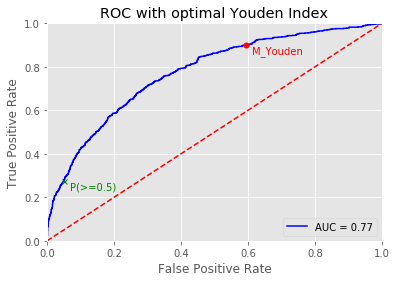


******* Using 0.5 Classification Threshold *******

[[1765  590]
 [ 260  485]]
the Accuracy is: 0.726
npv: 0.872
the classification_report:
               precision    recall  f1-score   support

         0.0      0.872     0.749     0.806      2355
         1.0      0.451     0.651     0.533       745

   micro avg      0.726     0.726     0.726      3100
   macro avg      0.661     0.700     0.669      3100
weighted avg      0.771     0.726     0.740      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.123
[[ 958 1397]
 [  74  671]]
the Accuracy is: 0.525
npv: 0.928
the classification_report:
               precision    recall  f1-score   support

         0.0      0.928     0.407     0.566      2355
         1.0      0.324     0.901     0.477       745

   micro avg      0.525     0.525     0.525      3100
   macro avg      0.626     0.654     0.521      3100
weighted avg      0.783     0.525     0.544      3100

time: 1.41 s


In [61]:
from parameters import save_boolean
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test, model_name='svc', folder_name='72')

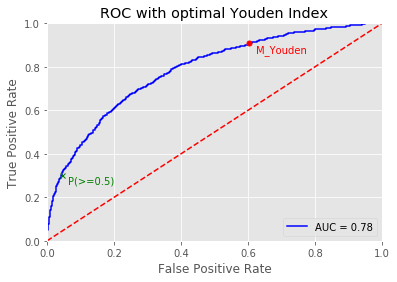


******* Using 0.5 Classification Threshold *******

[[2254  101]
 [ 518  227]]
the Accuracy is: 0.800
npv: 0.813
the classification_report:
               precision    recall  f1-score   support

         0.0      0.813     0.957     0.879      2355
         1.0      0.692     0.305     0.423       745

   micro avg      0.800     0.800     0.800      3100
   macro avg      0.753     0.631     0.651      3100
weighted avg      0.784     0.800     0.770      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.115
[[ 932 1423]
 [  68  677]]
the Accuracy is: 0.519
npv: 0.932
the classification_report:
               precision    recall  f1-score   support

         0.0      0.932     0.396     0.556      2355
         1.0      0.322     0.909     0.476       745

   micro avg      0.519     0.519     0.519      3100
   macro avg      0.627     0.652     0.516      3100
weighted avg      0.785     0.519     0.536      3100

time: 379 ms


In [65]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost', folder_name='72')

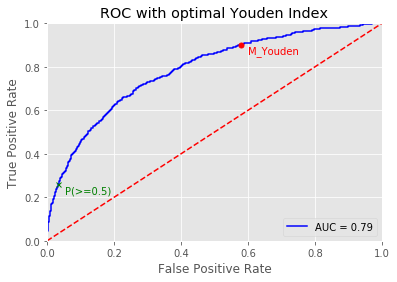


******* Using 0.5 Classification Threshold *******

[[2275   80]
 [ 552  193]]
the Accuracy is: 0.796
npv: 0.805
the classification_report:
               precision    recall  f1-score   support

         0.0      0.805     0.966     0.878      2355
         1.0      0.707     0.259     0.379       745

   micro avg      0.796     0.796     0.796      3100
   macro avg      0.756     0.613     0.629      3100
weighted avg      0.781     0.796     0.758      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.137
[[ 992 1363]
 [  73  672]]
the Accuracy is: 0.537
npv: 0.931
the classification_report:
               precision    recall  f1-score   support

         0.0      0.931     0.421     0.580      2355
         1.0      0.330     0.902     0.483       745

   micro avg      0.537     0.537     0.537      3100
   macro avg      0.631     0.662     0.532      3100
weighted avg      0.787     0.537     0.557      3100

time: 584 ms


In [66]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test, model_name='rf', folder_name='72')

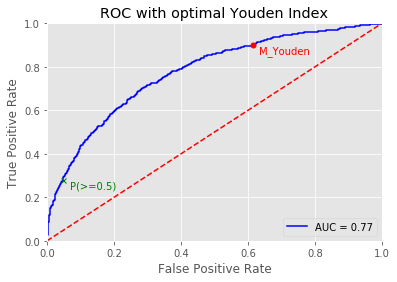


******* Using 0.5 Classification Threshold *******

[[2244  111]
 [ 535  210]]
the Accuracy is: 0.792
npv: 0.807
the classification_report:
               precision    recall  f1-score   support

         0.0      0.807     0.953     0.874      2355
         1.0      0.654     0.282     0.394       745

   micro avg      0.792     0.792     0.792      3100
   macro avg      0.731     0.617     0.634      3100
weighted avg      0.771     0.792     0.759      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.114
[[ 910 1445]
 [  73  672]]
the Accuracy is: 0.510
npv: 0.926
the classification_report:
               precision    recall  f1-score   support

         0.0      0.926     0.386     0.545      2355
         1.0      0.317     0.902     0.470       745

   micro avg      0.510     0.510     0.510      3100
   macro avg      0.622     0.644     0.507      3100
weighted avg      0.780     0.510     0.527      3100

time: 420 ms


In [67]:
# logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test)
logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test, model_name='logreg', folder_name='72')

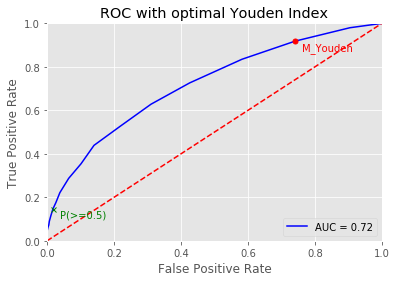


******* Using 0.5 Classification Threshold *******

[[2329   26]
 [ 660   85]]
the Accuracy is: 0.779
npv: 0.779
the classification_report:
               precision    recall  f1-score   support

         0.0      0.779     0.989     0.872      2355
         1.0      0.766     0.114     0.199       745

   micro avg      0.779     0.779     0.779      3100
   macro avg      0.772     0.552     0.535      3100
weighted avg      0.776     0.779     0.710      3100


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.080
[[ 611 1744]
 [  61  684]]
the Accuracy is: 0.418
npv: 0.909
the classification_report:
               precision    recall  f1-score   support

         0.0      0.909     0.259     0.404      2355
         1.0      0.282     0.918     0.431       745

   micro avg      0.418     0.418     0.418      3100
   macro avg      0.595     0.589     0.417      3100
weighted avg      0.758     0.418     0.410      3100

time: 3.7 s


In [69]:
knn_eval= classifier_eval(knn, x=np.array(x_test), y=y_test, model_name='knn', folder_name='72')

# classification performance table

In [70]:
def save_df(df):
    """
    simple function for saving result table
    """
    
    address=str(repository_path)+'/tables/{}'.format(folder)
    if not os.path.exists(address):
        print(address)
        os.makedirs(address)
    pd.DataFrame(df).to_csv(Path(address+'/%s_model_summary.csv' %(date)))


time: 3.72 ms


In [72]:
test_summary_df= pd.DataFrame([rf_eval,
                             #logreg_eval,
                               logreg_eval,
                             xgboost_eval,
                             svc_eval,
                              knn_eval])
test_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)

save_df(test_summary_df)
print(test_summary_df)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/24_hr_window
        auc        f1                   model       npv  precision    recall
0  0.786154  0.483453  RandomForestClassifier  0.931455   0.330221  0.902013
1  0.774842  0.469602      LogisticRegression  0.925738   0.317430  0.902013
2  0.784085  0.475923           XGBClassifier  0.932000   0.322381  0.908725
3  0.772861  0.477071                     SVC  0.928295   0.324468  0.900671
4  0.719433  0.431138    KNeighborsClassifier  0.909226   0.281713  0.918121
time: 16.8 ms


# generating publication stacked roc curve 

In [75]:
def roc_publishing(model, x=x, y=y, proba_input=False,pos_label=1, print_default=True, model_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    model_name=type(model).__name__

    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
    
    return(fpr, tpr, roc_auc, roc_df, idx)
    

time: 15.1 ms


In [76]:
# plt.style.use('seaborn-white')
# plt.rcParams['figure.figsize'] = [5, 5]

# fpr, tpr, roc_auc, roc_df, idx= roc_publishing(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost')

# plt.title('ROC with optimal Youden Index')
# ax= plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')

# #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
# og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
# plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="purple")
# plt.annotate(s="P(0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='purple', size=14, weight='bold') #textcoords

# plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
# plt.annotate(s="P(0.12)",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r', size=14, weight='bold' ) #textcoords
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate', size=14)
# plt.xlabel('False Positive Rate', size=14)

# plt.show()


time: 3.69 ms


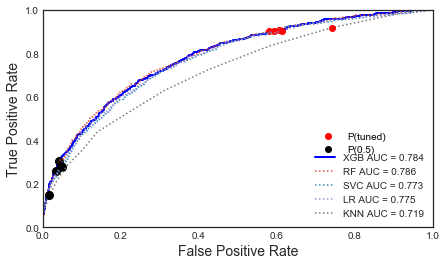

time: 5.77 s


In [87]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = [7, 4]
##########xgb
model_name='XGB'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost')
#plt.title('ROC with optimal Youden Index')
ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#plt.annotate(s="P(0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='purple', size=14, weight='bold') #textcoords
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
#plt.annotate(s="P(0.12)",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r', size=14, weight='bold' ) #textcoords

###########rf
model_name='RF'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(rf, x=np.array(x_test), y=y_test, model_name='rf')
ax2= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##

###########svc
model_name='SVC'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(svc, x=np.array(x_test), y=y_test, model_name='svc')
ax3= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##

###########logreg
model_name='LR'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(logreg2, x=np.array(x_test), y=y_test, model_name='lr')
ax4= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##

###########knn
model_name='KNN'
fpr, tpr, roc_auc, roc_df, idx= roc_publishing(knn, x=np.array(x_test), y=y_test, model_name='knn')
ax5= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc),linestyle='dotted')
og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
ax6=plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
ax7=plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
plt.legend(loc = 'lower right')

#plt.legend((ax1,ax2,ax3,ax4,ax5,ax6,ax7), loc = 'lower right')
plt.annotate(s="P(0.5)",xy=(0.78, 0.345),color='black', size=10) #textcoords
plt.plot(0.73, 0.36, 'ro', color='black')
plt.annotate(s="P(tuned)",xy=(0.78, 0.405),color='black', size=10) #textcoords
plt.plot(0.73, 0.42, 'ro', color='r')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', size=14)
plt.xlabel('False Positive Rate', size=14)

saveplot(plt,'stacked_roc')

plt.show()

# variable importance

In [78]:
def var_imp(model,folder_name,model_name, n_var=4, save=True):
    model_name=type(model).__name__
    plot_title= "Top {} {} {} Variable Importance".format(n_var, folder_name,model_name)
    feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
    topn=feat_importances.nlargest(n_var).sort_values()
    ax=topn.plot(kind='barh', x='variable importance', title=plot_title)#.xlabel("xlab")
    ax.set_xlabel("Variable Importance")
    if save==True:
        saveplot(figure_name=plot_title)
    return(topn)


time: 7.66 ms


In [79]:
#log reg important features

def coef_feature_importance(model):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-10:]#[0]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(x_test.columns)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')

    plt.tight_layout()   
    plt.show()
    return(list(np.array(x_test.columns)[sorted_idx][-10:]), feature_importance[sorted_idx])

time: 15 ms


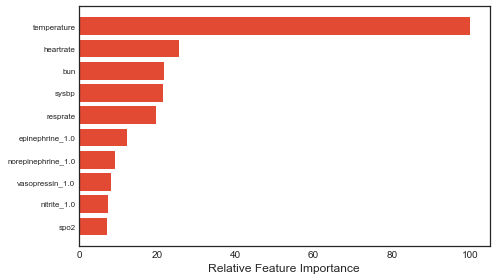

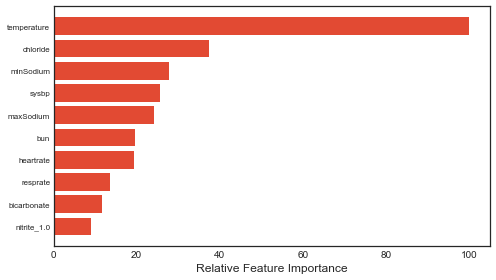

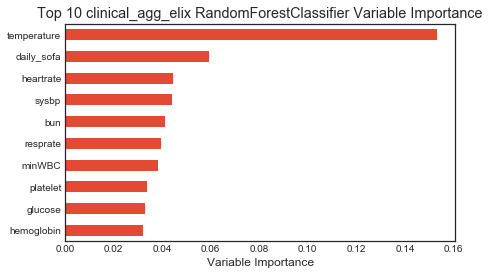

time: 556 ms


In [80]:
logreg_10features,logreg_top10 =coef_feature_importance(logreg2)
logreg_top10=pd.Series(logreg_top10,logreg_10features)

svc_10features,svc_top10 =coef_feature_importance(svc)
svc_top10=pd.Series(svc_top10,svc_10features)


xgb_10features=var_imp(xgboost,"clinical_agg_elix","xgboost", n_var=10, save=False)
rf_10features=var_imp(rf,"clinical_agg_elix","rf", n_var=10, save=False)
xgb_top10=(xgb_10features/xgb_10features[-1])*100
rf_top10=(rf_10features/rf_10features[-1])*100
xgb_10features=list(xgb_10features.reset_index()['index'])
rf_10features=list(rf_10features.reset_index()['index'])

In [120]:
df_base=pd.DataFrame(index=set(logreg_10features + svc_10features+ rf_10features +xgb_10features))
df_base['xgb']=xgb_top10
df_base['rf']=rf_top10
df_base['svc']=svc_top10
df_base['lr']=logreg_top10

##use for curosity
varimp_names=list(set(logreg_10features + svc_10features+ rf_10features +xgb_10features))


##use and edit variable names for publication:
# adjusted_names=['chloride',
#                  'heartrate',
#                  'bicarbonate',
#                  'temperature',
#                  'daily_sofa',
#                  'glucose',
#                  'meanArtPress',
#                  'minSodium',
#                  'nitrite (Y/N)',
#                  'bands_>10 (Y/N)',
#                  'bands_absent (Y/N)',
#                  'yearsold',
#                  'epinephrine (Y/N)',
#                  'minWBC',
#                  'SpO2',
#                  'sysBP',
#                  'leukocyte (Y/N)',
#                  'norepinephrine (Y/N)',
#                  'respriratory_volume',
#                 'dopamine (Y/N)']

df_base.index=varimp_names
df_base.sort_values('xgb', ascending=False)

,xgb,rf,svc,lr
norepinephrine_1.0,100.000000,NaN,NaN,9.126113
ibands_absent,38.663788,NaN,NaN,NaN
daily_sofa,28.545439,84.699637,NaN,NaN
"pao2fio2ratio_(475, 3000]",26.300789,NaN,NaN,NaN
leukocyte_1.0,24.755850,NaN,NaN,NaN
sysbp,24.028185,77.202572,25.627273,21.512397
resprate,20.406155,69.311530,13.617363,19.762370
ibands_>10,18.070879,NaN,NaN,NaN
temperature,17.950611,100.000000,100.000000,100.000000
vent_recieved_2.0,15.848962,NaN,NaN,NaN


time: 36.9 ms


In [148]:
def roc_name_adjust(varimp_names):
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
            'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
            'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 12.5 ms


In [149]:
adjusted_names = roc_name_adjust(varimp_names)
df_base.index=adjusted_names
df_base.sort_values('xgb', ascending=False)

,xgb,rf,svc,lr
norepinephrine (Y/N),100.000000,NaN,NaN,9.126113
bands (missing),38.663788,NaN,NaN,NaN
daily_sofa,28.545439,84.699637,NaN,NaN
PaO2:FiO2 (475-3000),26.300789,NaN,NaN,NaN
leukocyte (Y/N),24.755850,NaN,NaN,NaN
sysbp,24.028185,77.202572,25.627273,21.512397
resprate,20.406155,69.311530,13.617363,19.762370
bands (>10),18.070879,NaN,NaN,NaN
temperature,17.950611,100.000000,100.000000,100.000000
mechanical ventilation recieved,15.848962,NaN,NaN,NaN


time: 12.7 ms


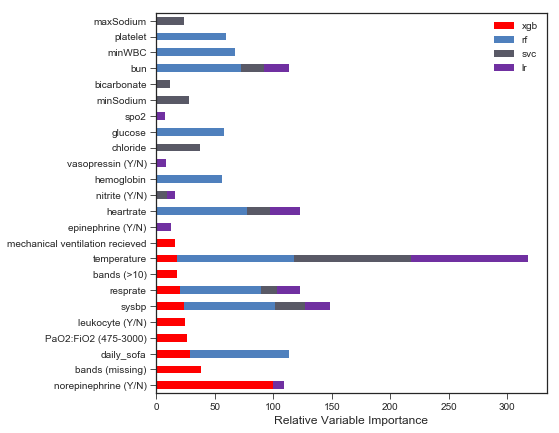

time: 1.13 s


In [150]:
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = [7, 7]
ax = df_base.sort_values('xgb', ascending=False).plot.barh(stacked=True,
                                                           grid=False,
                                                           color=['r',(0.31,0.50,0.74),(0.35,0.35,0.40),(0.44,0.19,0.63)])#facecolor='w')#rot=0) #(0.96,0.59,0.27)
ax.set_facecolor('w')
ax.set_xlabel("Relative Variable Importance")

saveplot(plt,'variable_importance')

# Model Saving

In [151]:
def model_save(model, model_name):
    import pickle
    modelpath=str(repository_path)+'/models/{}'.format(folder)

    if not os.path.exists(modelpath):
        print(modelpath)
        os.makedirs(modelpath)

    filename = str(modelpath)+'/finalized_{}.sav'.format(model_name)
    pickle.dump(model, open(filename, 'wb'))

time: 5.62 ms


In [152]:
model_save(xgboost,'xgboost')
model_save(rf,'rf')
model_save(logreg,'logreg')
model_save(svc,'svc')
model_save(knn,'knn')

time: 99.8 ms
